# Imports

In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=7cdb52f6ae7ed76e6b354aba077b10a2825a058057a84da5e24ce3217e29ab6d
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import medmnist

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Data Loading

In [ ]:
# medmnist.INFO["retinamnist"]
medmnist.INFO["dermamnist"]

{'MD5': '0744692d530f8e62ec473284d019b0c7',
 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.',
 'label': {'0': 'actinic keratoses and intraepithelial carcinoma',
  '1': 'basal cell carcinoma',
  '2': 'benign keratosis-like lesions',
  '3': 'dermatofibroma',
  '4': 'melanoma',
  '5': 'melanocytic nevi',
  '6': 'vascular lesions'},
 'license': 'CC BY-NC 4.0',
 'n_channels': 3,
 'n_samples': {'test': 2005, 'train': 7007, 'val': 1003},
 'python_class': 'DermaMNIST',
 'task': 'multi-class',
 'url': 'https://zenodo.org/record/5208230/files/dermamnist.npz?download=1'}

## Download

In [ ]:
train_dataset = medmnist.dataset.DermaMNIST(split='train', download=True)
test_dataset = medmnist.dataset.DermaMNIST(split='test', download=True)
val_dataset = medmnist.dataset.DermaMNIST(split='val', download=True)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


## To Numpy

In [ ]:
X_train = train_dataset.imgs
X_val = val_dataset.imgs
X_test = test_dataset.imgs

y_train = train_dataset.labels
y_val = val_dataset.labels
y_test = test_dataset.labels

# Data Understanding

## Shape

In [ ]:
print("train:",X_train.shape,y_train.shape)
print("test:",X_test.shape,y_test.shape)
print('val:',X_val.shape,y_val.shape)

train: (7007, 28, 28, 3) (7007, 1)
test: (2005, 28, 28, 3) (2005, 1)
val: (1003, 28, 28, 3) (1003, 1)


## Counts per-category

In [ ]:
# labels =  list(medmnist.INFO['dermamnist']['label'].values())
labels = ['akic',
 'bccar',
 'bkll',
 'df',
 'melanoma',
 'mel-nevi',
 'vas-lesi']

labels

['akic', 'bccar', 'bkll', 'df', 'melanoma', 'mel-nevi', 'vas-lesi']

### Train Data

In [ ]:
print(("-"*10)+"Train data"+("-"*10))

train_labels = np.array([i[0] for i in y_train])

no_of_samples = np.bincount(train_labels)

print(pd.DataFrame({"Counts":no_of_samples,
             "Percentage":no_of_samples/sum(no_of_samples)*100},
             index=labels))

----------Train data----------
          Counts  Percentage
akic         228    3.253889
bccar        359    5.123448
bkll         769   10.974740
df            80    1.141715
melanoma     779   11.117454
mel-nevi    4693   66.975881
vas-lesi      99    1.412873


### Test Data

In [ ]:
print(("-"*10)+"Test data"+("-"*10))

test_labels = np.array([i[0] for i in y_test])

no_of_samples = np.bincount(test_labels)

print(pd.DataFrame({"Counts":no_of_samples,
             "Percentage":no_of_samples/sum(no_of_samples)*100},
             index=labels))

----------Test data----------
          Counts  Percentage
akic          66    3.291771
bccar        103    5.137157
bkll         220   10.972569
df            23    1.147132
melanoma     223   11.122195
mel-nevi    1341   66.882793
vas-lesi      29    1.446384


### Val Data

In [ ]:
print(("-"*10)+"Val data"+("-"*10))

val_labels = np.array([i[0] for i in y_val])

no_of_samples = np.bincount(val_labels)

print(pd.DataFrame({"Counts":no_of_samples,
             "Percentage":no_of_samples/sum(no_of_samples)*100},
             index=labels))

----------Val data----------
          Counts  Percentage
akic          33    3.290130
bccar         52    5.184447
bkll         110   10.967099
df            12    1.196411
melanoma     111   11.066800
mel-nevi     671   66.899302
vas-lesi      14    1.395813


## Visualisation

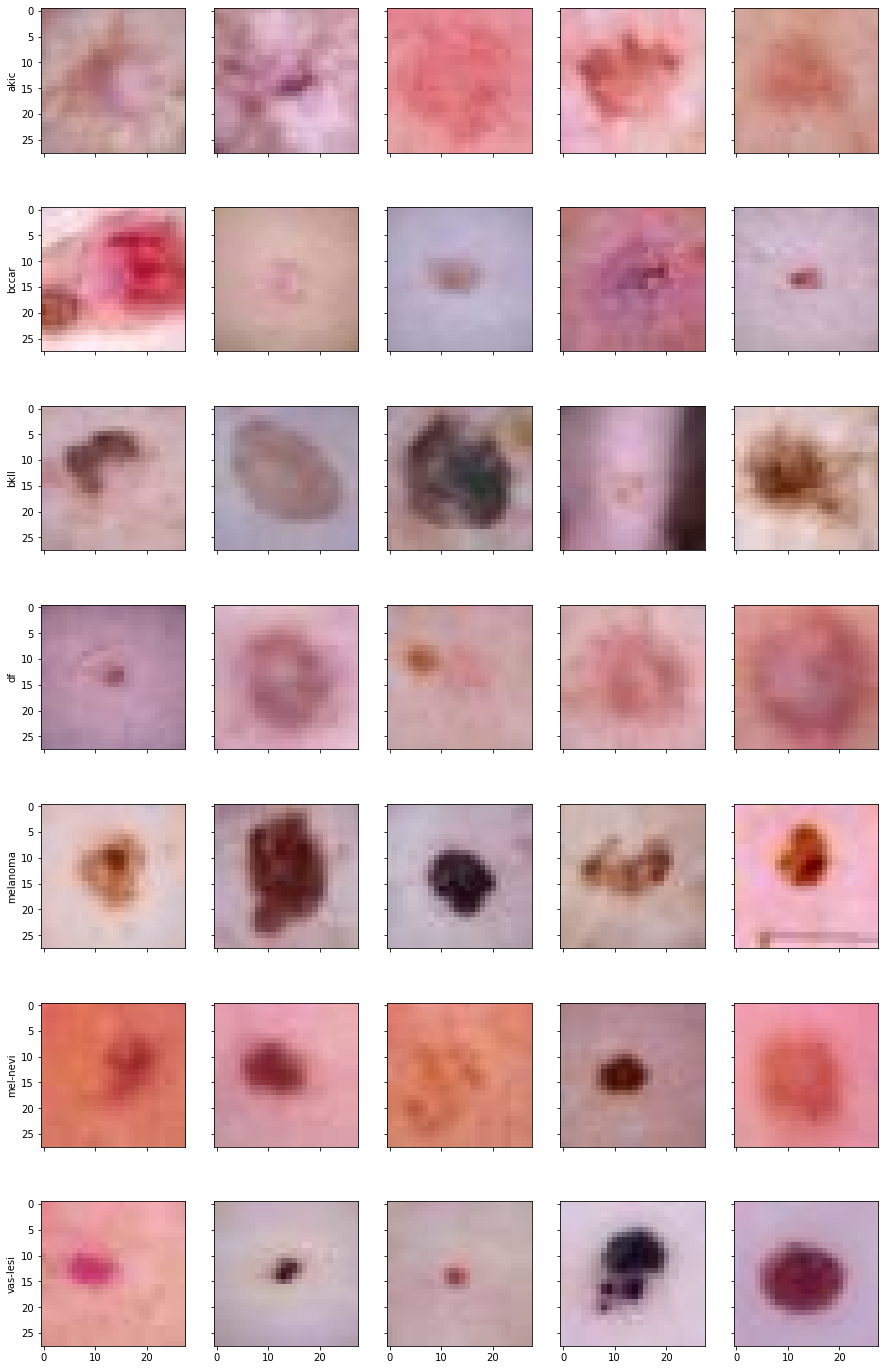

In [ ]:
fig, ax = plt.subplots(7, 5)
fig.set_figheight(25)
fig.set_figwidth(15)
for classes in range (7):
    for i, inx in enumerate(np.where(y_train==classes)[0][:5]):
        ax[classes,i].imshow(X_train[inx])
        ax[classes,i].set_ylabel(labels[classes],fontsize = 10.0)
        ax[classes,i].label_outer()

# Data Pre-Processing

## Re-sampling

### Train

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


no_of_samples = np.bincount(train_labels)

resampling_dict = {0: no_of_samples[0]*7,
                   1: no_of_samples[1]*5,
                   2: no_of_samples[2]*2,
                   3: no_of_samples[3]*20,
                   4: no_of_samples[4]*2,
                   5: no_of_samples[5],
                   6: no_of_samples[6]*20}

# flattening X to suite the library requirements
X_train = X_train.reshape(X_train.shape[0], -1)

# over sampling all categories except 5
oversample = RandomOverSampler(sampling_strategy=resampling_dict)
X_train_resampled , y_train_resampled = oversample.fit_resample(X_train, y_train)
print('Over sampling : {}'.format(np.bincount(y_train_resampled)))

resampling_dict[5] = no_of_samples[5]//2
# under sampling category 5
undersample = RandomUnderSampler(sampling_strategy=resampling_dict)
X_train_resampled , y_train_resampled = undersample.fit_resample(X_train_resampled, y_train_resampled)
print('Under sampling : {}'.format(np.bincount(y_train_resampled)))

# re-shaping X back to it's original shape
X_train_resampled = X_train_resampled.reshape(-1,28,28,3)
X_train = X_train.reshape(-1,28,28,3)

Over sampling : [1596 1795 1538 1600 1558 4693 1980]
Under sampling : [1596 1795 1538 1600 1558 2346 1980]


### Test

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


no_of_samples = np.bincount(test_labels)

resampling_dict = {0: no_of_samples[0]*7,
                   1: no_of_samples[1]*5,
                   2: no_of_samples[2]*2,
                   3: no_of_samples[3]*20,
                   4: no_of_samples[4]*2,
                   5: no_of_samples[5],
                   6: no_of_samples[6]*20}

# flattening X to suite the library requirements
X_test = X_test.reshape(X_test.shape[0], -1)

# over sampling all categories except 5
oversample = RandomOverSampler(sampling_strategy=resampling_dict)
X_test_resampled , y_test_resampled = oversample.fit_resample(X_test, y_test)
print('Over sampling : {}'.format(np.bincount(y_test_resampled)))

resampling_dict[5] = no_of_samples[5]//2
# under sampling category 5
undersample = RandomUnderSampler(sampling_strategy=resampling_dict)
X_test_resampled , y_test_resampled = undersample.fit_resample(X_test_resampled, y_test_resampled)
print('Under sampling : {}'.format(np.bincount(y_test_resampled)))

# re-shaping X back to it's original shape
X_test_resampled = X_test_resampled.reshape(-1,28,28,3)
X_test = X_test.reshape(-1,28,28,3)

Over sampling : [ 462  515  440  460  446 1341  580]
Under sampling : [462 515 440 460 446 670 580]


### Val

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


no_of_samples = np.bincount(val_labels)

resampling_dict = {0: no_of_samples[0]*7,
                   1: no_of_samples[1]*5,
                   2: no_of_samples[2]*2,
                   3: no_of_samples[3]*20,
                   4: no_of_samples[4]*2,
                   5: no_of_samples[5],
                   6: no_of_samples[6]*20}

# flattening X to suite the library requirements
X_val = X_val.reshape(X_val.shape[0], -1)

# over sampling all categories except 5
oversample = RandomOverSampler(sampling_strategy=resampling_dict)
X_val_resampled , y_val_resampled = oversample.fit_resample(X_val, y_val)
print('Over sampling : {}'.format(np.bincount(y_val_resampled)))

resampling_dict[5] = no_of_samples[5]//2
# under sampling category 5
undersample = RandomUnderSampler(sampling_strategy=resampling_dict)
X_val_resampled , y_val_resampled = undersample.fit_resample(X_val_resampled, y_val_resampled)
print('Under sampling : {}'.format(np.bincount(y_val_resampled)))

# re-shaping X back to it's original shape
X_val_resampled = X_val_resampled.reshape(-1,28,28,3)
X_val = X_val.reshape(-1,28,28,3)

Over sampling : [231 260 220 240 222 671 280]
Under sampling : [231 260 220 240 222 335 280]


## Counts after Re-sampling

In [ ]:
no_of_samples = np.bincount(y_train_resampled)

print(pd.DataFrame({"Counts":no_of_samples,
             "Percentage":no_of_samples/sum(no_of_samples)*100},
             index=labels))
print("Total : ", sum(no_of_samples))

          Counts  Percentage
akic        1596   12.857488
bccar       1795   14.460646
bkll        1538   12.390236
df          1600   12.889712
melanoma    1558   12.551357
mel-nevi    2346   18.899541
vas-lesi    1980   15.951019
Total :  12413


In [ ]:
no_of_samples = np.bincount(y_test_resampled)

print(pd.DataFrame({"Counts":no_of_samples,
             "Percentage":no_of_samples/sum(no_of_samples)*100},
             index=labels))
print("Total : ", sum(no_of_samples))

          Counts  Percentage
akic         462   12.930311
bccar        515   14.413658
bkll         440   12.314582
df           460   12.874335
melanoma     446   12.482508
mel-nevi     670   18.751749
vas-lesi     580   16.232858
Total :  3573


In [ ]:
no_of_samples = np.bincount(y_val_resampled)

print(pd.DataFrame({"Counts":no_of_samples,
             "Percentage":no_of_samples/sum(no_of_samples)*100},
             index=labels))
print("Total : ", sum(no_of_samples))

          Counts  Percentage
akic         231   12.919463
bccar        260   14.541387
bkll         220   12.304251
df           240   13.422819
melanoma     222   12.416107
mel-nevi     335   18.736018
vas-lesi     280   15.659955
Total :  1788


## Image data generation using TF

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'wrap')

train_data = train_datagen.flow(X_train_resampled, to_categorical(y_train_resampled),
                                batch_size=50,
                                seed=1)


val_datagen = ImageDataGenerator(rescale = 1./255)

val_data = val_datagen.flow(X_val_resampled, to_categorical(y_val_resampled),
                             batch_size=50,
                             seed=1)

## Final data shape

In [ ]:
print('Train Set:      X:{} Y:{}'.format(train_data.x.shape, train_data.y.shape))
print('Validation Set: X:{} Y:{}'.format(val_data.x.shape, val_data.y.shape))
print('Test Set :      X:{} Y:{}'.format(X_test.shape, y_test.shape))

Train Set:      X:(12413, 28, 28, 3) Y:(12413, 7)
Validation Set: X:(1788, 28, 28, 3) Y:(1788, 7)
Test Set :      X:(2005, 28, 28, 3) Y:(2005, 1)


# Model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

## Architecture

### Define

In [ ]:
input_layer = Input(shape=(28,28,3))

# convolution block 1
cb11 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(input_layer)
cb12 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb11)
maxpl1 = MaxPool2D((2,2))(cb12)

#convolution block 2
cb21 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl1)
cb22 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb21)
maxpl2 = MaxPool2D((2,2))(cb22)

#convolution block 3
cb31 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl2)
cb32 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb31)
maxpl3 = MaxPool2D((2,2))(cb32)

#convolution block 4
cb41 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl3)
cb42 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb41)
cb43 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb42)
maxpl4 = MaxPool2D((2,2))(cb43)

# artificial neural network block
flat   = Flatten()(maxpl4)
dense1 = Dense(1024, activation="relu")(flat)
dense2 = Dense(1024, activation="relu")(dense1)
dense3 = Dense(1024, activation="relu")(dense2)
output = Dense(7, activation="softmax")(dense3)
model = Model(inputs=input_layer, outputs=output)

### Compile

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(0.0001, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])#keras.metrics.Accuracy())

### Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       590080    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       590080    
                                                             

## Training

In [ ]:
batch_size = 100
epochs = 50
model_history = model.fit(train_data,
                          steps_per_epoch= int(train_data.n/batch_size),
                          epochs=epochs,
                          validation_data=val_data,
                          validation_steps=int(val_data.n/batch_size))

Epoch 1/50
124/124 [==============================] - 16s 43ms/step - loss: 1.8939 - acc: 0.1944 - val_loss: 1.7745 - val_acc: 0.2824
Epoch 2/50
124/124 [==============================] - 5s 38ms/step - loss: 1.7112 - acc: 0.2668 - val_loss: 1.6245 - val_acc: 0.3247
Epoch 3/50
124/124 [==============================] - 5s 39ms/step - loss: 1.6324 - acc: 0.2892 - val_loss: 1.5349 - val_acc: 0.4176
Epoch 4/50
124/124 [==============================] - 6s 48ms/step - loss: 1.4849 - acc: 0.3923 - val_loss: 1.4212 - val_acc: 0.4282
Epoch 5/50
124/124 [==============================] - 8s 66ms/step - loss: 1.4053 - acc: 0.4216 - val_loss: 1.3620 - val_acc: 0.4576
Epoch 6/50
124/124 [==============================] - 5s 39ms/step - loss: 1.3492 - acc: 0.4455 - val_loss: 1.3418 - val_acc: 0.4635
Epoch 7/50
124/124 [==============================] - 5s 38ms/step - loss: 1.3066 - acc: 0.4689 - val_loss: 1.2823 - val_acc: 0.4588
Epoch 8/50
124/124 [==============================] - 5s 38ms/step -

In [ ]:
model.save("dermamnist_model")

INFO:tensorflow:Assets written to: dermamnist_model/assets


In [ ]:
! zip -r dermamodel.zip dermamnist_model

In [ ]:
model_history.params

### Training performance

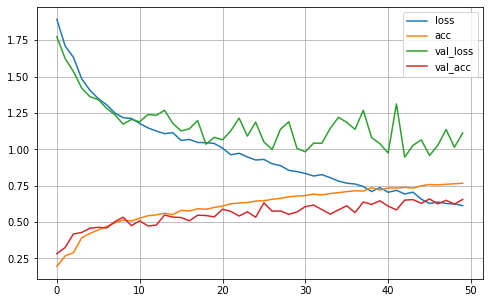

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Testing

### Evaluate

In [ ]:
model.evaluate(X_test_resampled/255, to_categorical(y_test_resampled))

112/112 [==============================] - 2s 11ms/step - loss: 1.2419 - acc: 0.6342


[1.2419342994689941, 0.634200930595398]

In [ ]:
y_proba = model.predict(X_test_resampled/255)
y_proba.round(2)

array([[0.37, 0.08, 0.23, ..., 0.3 , 0.02, 0.  ],
       [0.26, 0.62, 0.03, ..., 0.  , 0.  , 0.  ],
       [0.63, 0.08, 0.15, ..., 0.1 , 0.04, 0.  ],
       ...,
       [0.  , 0.01, 0.02, ..., 0.01, 0.02, 0.94],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred[:10]

array([0, 1, 0, 0, 5, 0, 0, 0, 3, 0])

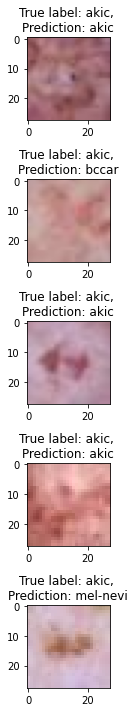

In [ ]:
y_pred_name = np.array(labels)[y_pred]

plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.imshow(X_test_resampled[i])
    plt.title('True label: {}, \nPrediction: {}'.format(labels[y_test[i].argmax()], y_pred_name[i]))
plt.tight_layout()

### Confusion matrix

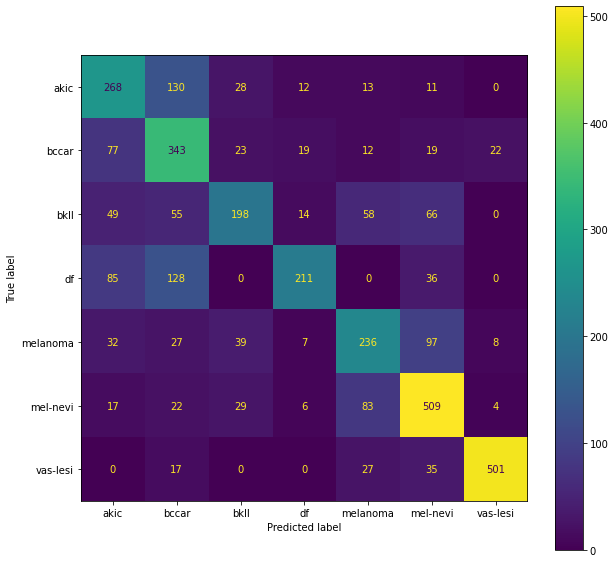

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_resampled, y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test_resampled, y_pred, target_names = labels))

              precision    recall  f1-score   support

        akic       0.51      0.58      0.54       462
       bccar       0.48      0.67      0.55       515
        bkll       0.62      0.45      0.52       440
          df       0.78      0.46      0.58       460
    melanoma       0.55      0.53      0.54       446
    mel-nevi       0.66      0.76      0.71       670
    vas-lesi       0.94      0.86      0.90       580

    accuracy                           0.63      3573
   macro avg       0.65      0.62      0.62      3573
weighted avg       0.66      0.63      0.63      3573



#RESNET50

In [ ]:
# Download data from Mnist
train_dataset = medmnist.dataset.DermaMNIST(split='train', download=True)
test_dataset = medmnist.dataset.DermaMNIST(split='test', download=True)
val_dataset = medmnist.dataset.DermaMNIST(split='val', download=True)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
# Dump data
train_dataset.save("temp_train")
test_dataset.save("temp_test")
val_dataset.save("temp_val")

100%|██████████| 1003/1003 [00:00<00:00, 3336.31it/s]


In [ ]:
# Read image names and their location details
import pandas as pd
train_df = pd.read_csv("temp_train/dermamnist.csv", header=None, names=["Train_Test", "Img", "Class"])
test_df = pd.read_csv("temp_test/dermamnist.csv", header=None, names=["Train_Test", "Img", "Class"])
val_df = pd.read_csv("temp_val/dermamnist.csv", header=None, names=["Train_Test", "Img", "Class"])

In [ ]:
# Create empty folders
import os
try:
  os.mkdir("data")
  os.mkdir("data/train")
  os.mkdir("data/test")
  os.mkdir("data/val")
  for label in labels:
    os.mkdir("data/train/"+str(label))
    os.mkdir("data/test/"+str(label))
    os.mkdir("data/val/"+str(label))
except:
  print("Location already exists")

In [ ]:
# Copy images to respective folders
import shutil
# shutil.copy2('/src/dir/file.ext', '/dst/dir/newname.ext')

for img_name, lab_id in zip(train_df.Img.to_list(), train_df.Class.to_list()):
  shutil.copy("temp_train/dermamnist/"+str(img_name), "data/train/"+str(labels[lab_id])+"/"+str(img_name))
for img_name, lab_id in zip(test_df.Img.to_list(), test_df.Class.to_list()):
  shutil.copy("temp_test/dermamnist/"+str(img_name), "data/test/"+str(labels[lab_id])+"/"+str(img_name))
for img_name, lab_id in zip(val_df.Img.to_list(), val_df.Class.to_list()):
  shutil.copy("temp_val/dermamnist/"+str(img_name), "data/val/"+str(labels[lab_id])+"/"+str(img_name))

In [ ]:
train_dir = "data/train/"
validation_dir = "data/val"

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, class_mode = 'binary', target_size = (32, 32))

validation_generator = test_datagen.flow_from_directory( validation_dir, class_mode = 'binary', target_size = (32, 32))

Found 7007 images belonging to 7 classes.
Found 1003 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape= (32, 32,3), include_top=False, weights="imagenet")

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow as tf

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

In [ ]:
base_model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
resnet_history = base_model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 50, epochs = 20)

Epoch 1/20
50/50 [==============================] - 23s 158ms/step - loss: -226.2101 - acc: 0.0456 - val_loss: -217.6883 - val_acc: 0.0518
Epoch 2/20
50/50 [==============================] - 7s 141ms/step - loss: -619.0414 - acc: 0.0494 - val_loss: -39.1611 - val_acc: 0.0518
Epoch 3/20
50/50 [==============================] - 6s 124ms/step - loss: -1111.2277 - acc: 0.0475 - val_loss: -2498.7400 - val_acc: 0.0518
Epoch 4/20
50/50 [==============================] - 6s 122ms/step - loss: -1829.4297 - acc: 0.0581 - val_loss: -514.3853 - val_acc: 0.0518
Epoch 5/20
50/50 [==============================] - 6s 121ms/step - loss: -2574.9578 - acc: 0.0494 - val_loss: -2787.3057 - val_acc: 0.0518
Epoch 6/20
50/50 [==============================] - 6s 121ms/step - loss: -3550.7571 - acc: 0.0507 - val_loss: -4460.4805 - val_acc: 0.0518
Epoch 7/20
50/50 [==============================] - 6s 122ms/step - loss: -4801.8804 - acc: 0.0475 - val_loss: -3033.9661 - val_acc: 0.0518
Epoch 8/20
50/50 [=======

In [ ]:
import cv2

X_train_large, X_test_large, X_val_large = [],[],[]
for xt in X_train:
  X_train_large.append(cv2.resize(xt, (32,32), interpolation = cv2.INTER_LINEAR))
for xtt in X_test:
  X_test_large.append(cv2.resize(xtt, (32,32), interpolation = cv2.INTER_LINEAR))
for xv in X_val:
  X_val_large.append(cv2.resize(xv, (32,32), interpolation = cv2.INTER_LINEAR))

X_train_large, X_test_large, X_val_large = np.array(X_train_large), np.array(X_test_large), np.array(X_val_large)

In [ ]:
base_model=model

In [ ]:
y_proba = base_model.predict(X_test/255)
y_pred = np.argmax(y_proba, axis=-1)
# y_pred=np.array([i[0] for i in y_pred ],dtype=np.int32)

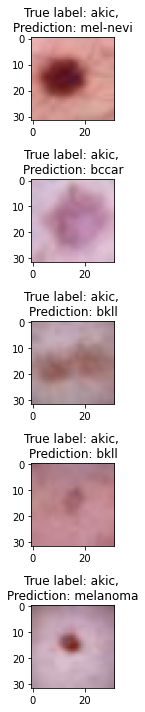

In [ ]:
y_pred_name = np.array(labels)[y_pred]

plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.imshow(X_test_large[i])
    plt.title('True label: {}, \nPrediction: {}'.format(labels[y_test[i].argmax()], y_pred_name[i]))
plt.tight_layout()

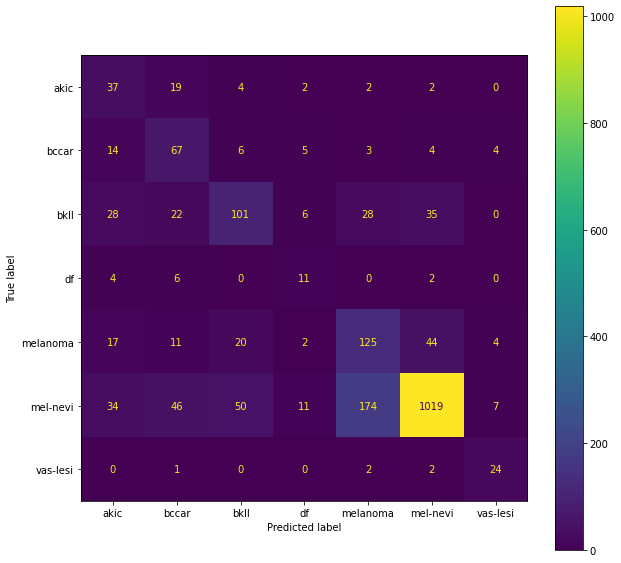

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names = labels))

              precision    recall  f1-score   support

        akic       0.28      0.56      0.37        66
       bccar       0.39      0.65      0.49       103
        bkll       0.56      0.46      0.50       220
          df       0.30      0.48      0.37        23
    melanoma       0.37      0.56      0.45       223
    mel-nevi       0.92      0.76      0.83      1341
    vas-lesi       0.62      0.83      0.71        29

    accuracy                           0.69      2005
   macro avg       0.49      0.61      0.53      2005
weighted avg       0.76      0.69      0.71      2005



#VGG16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'wrap')
X_train = tf.image.resize(X_train, [32,32]) # if we want to resize
X_val = tf.image.resize(X_val, [32,32]) # if we want to resize

X_test =tf.image.resize(X_test, [32,32]) # if we want to resize

train_data = train_datagen.flow(X_train, to_categorical(y_train),
                                batch_size=50,
                                seed=1)


val_datagen = ImageDataGenerator(rescale = 1./255)

val_data = val_datagen.flow(X_val, to_categorical(y_val),
                             batch_size=50,
                             seed=1)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (32,32,3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.python.keras import layers
from keras import metrics
# Flatten the output layer to 1 dimension
x = layers.Flatten(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)
#[metrics.mae, metrics.categorical_accuracy]
#'acc'
#['accuracy', f1_score, precision, recall]
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = 'acc')

In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)